## Data Initialisation

Define X and y here

In [1]:
import cv2 
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
import numpy as np
from tqdm import tqdm
import os

X = []
y = []
w = 1200

for file in tqdm(os.listdir("./Data/Ailleurs")):
    image = cv2.imread ("./Data/Ailleurs/" + file ,0)
    cv2.resize(image, (w,w))
    glcm = graycomatrix(image, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    
    img_data = []
    img_data.append(graycoprops(glcm, 'contrast')[0, 0])
    img_data.append(graycoprops(glcm, 'dissimilarity')[0, 0])
    img_data.append(graycoprops(glcm, 'homogeneity')[0, 0])
#     img_data.append(graycoprops(glcm, 'ASM')[0, 0])
#     img_data.append(graycoprops(glcm, 'energy')[0, 0])
    img_data.append(graycoprops(glcm, 'correlation')[0, 0])
    
    X.append(img_data)
    y.append(0)
    
    
for file in tqdm(os.listdir("./Data/Mer")):
    image = cv2.imread ("./Data/Mer/" + file ,0)
    cv2.resize(image, (w,w))
    glcm = graycomatrix(image, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    img_data = []
    img_data.append(graycoprops(glcm, 'contrast')[0, 0])
    img_data.append(graycoprops(glcm, 'dissimilarity')[0, 0])
    img_data.append(graycoprops(glcm, 'homogeneity')[0, 0])
#     img_data.append(graycoprops(glcm, 'ASM')[0, 0])
#     img_data.append(graycoprops(glcm, 'energy')[0, 0])
    img_data.append(graycoprops(glcm, 'correlation')[0, 0])
    
    X.append(img_data)
    y.append(1)

100%|████████████████████████████████████████| 201/201 [00:00<00:00, 205.34it/s]


In [10]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_histogram(filename):
    r = []
    g = []
    b = []

    for i in range(256):
        r.append(0)
        g.append(0)
        b.append(0)

    image = Image.open(filename)
    image = image.convert("RGB")

    for i in range(image.width):
        for j in range(image.height):
            r_pxl, g_pxl, b_pxl = image.getpixel((i, j))
            r[r_pxl] += 1 / (image.width * image.height)
            g[g_pxl] += 1 / (image.width * image.height)
            b[b_pxl] += 1 / (image.width * image.height)
    return r, g, b

X = []
y = []

for file in tqdm(os.listdir("./Data/Ailleurs")):
    r, g, b = get_histogram("./Data/Ailleurs/" + file)
    data = g
    data.extend(b)
    X.append(data)
    y.append(0)
    
for file in tqdm(os.listdir("./Data/Mer")):
    r, g, b = get_histogram("./Data/Mer/" + file)
    data = g
    data.extend(b)
    X.append(data)
    y.append(1)

100%|█████████████████████████████████████████| 206/206 [02:53<00:00,  1.19it/s]


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure
from skimage.io import imread
from skimage.transform import rescale, resize
from tqdm import tqdm

X = []
y = []

w = 1200
scale = 1/3
ppc = (16,16) # pixels_per_cell
cpb = (1,1) # cells_per_block
ori = 16 # orientations
bln = 'L2' # {‘L1’, ‘L1-sqrt’, ‘L2’, ‘L2-Hys’}

for file in tqdm(os.listdir("./Data/Ailleurs")):
    image = imread('./Data/Ailleurs/' + file, as_gray=True)
    image = resize(image, (w, w))
    image = rescale(image, scale, mode='reflect')
    
    img_hog = hog(image, orientations=ori, pixels_per_cell=ppc,
                    cells_per_block=cpb, feature_vector=True, block_norm=bln)
    
    X.append(img_hog)
    y.append(0)
    
for file in tqdm(os.listdir("./Data/Mer")):
    image = imread('./Data/Mer/' + file, as_gray=True)
    image = resize(image, (w, w))
    image = rescale(image, scale, mode='reflect')
    
    img_hog = hog(image, orientations=ori, pixels_per_cell=ppc,
                    cells_per_block=cpb, feature_vector=True, block_norm=bln)
    
    X.append(img_hog)
    y.append(1)

100%|█████████████████████████████████████████| 206/206 [00:13<00:00, 15.45it/s]


## Classifiers Comparison

In [2]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.neighbors import KNeighborsClassifier

classifiers = {
    "GaussianNB" : GaussianNB(),
    "RandomForestClassifier" : RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "AdaBoostClassifier" : AdaBoostClassifier(),
    "DecisionTreeClassifier" : DecisionTreeClassifier(max_depth=5),
    "MLPClassifier" : MLPClassifier(alpha=1, max_iter=1000),
    "KNeighborsClassifier" : KNeighborsClassifier(3),
    "GaussianProcessClassifier" : GaussianProcessClassifier(1.0 * RBF(1.0)),
    "LinearSVM": SVC(kernel="linear", C=0.025)
}

clf_scores = {}

for clf_name in classifiers:
    clf = classifiers[clf_name]
    clf_score = 0
    
    # average on 20 runs
    for i in tqdm(range(20)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
        clf.fit(X_train, y_train)
        y_predits = clf.predict(X_test)
        clf_score += accuracy_score(y_test, y_predits)
    clf_score /= 20
    clf_scores[clf_name] = clf_score

100%|███████████████████████████████████████████| 20/20 [00:07<00:00,  2.69it/s]


In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
clf = SVC()
clf_score = 0
    
# average on 50 runs
for i in tqdm(range(50)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    clf.fit(X_train, y_train)
    y_predits = clf.predict(X_test)
    clf_score += accuracy_score(y_test, y_predits)
clf_score /= 50
clf_score

100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.39it/s]


0.7571084337349396

#### Sort and print the results

In [3]:
clf_scores = dict(sorted(clf_scores.items(), key=lambda item: item[1], reverse=True))
clf_scores

{'LinearSVM': 0.7182926829268294,
 'GaussianNB': 0.7060975609756098,
 'RandomForestClassifier': 0.6865853658536585,
 'GaussianProcessClassifier': 0.6737804878048779,
 'AdaBoostClassifier': 0.6658536585365854,
 'DecisionTreeClassifier': 0.6469512195121949,
 'MLPClassifier': 0.6426829268292683,
 'KNeighborsClassifier': 0.6073170731707318}

#### Visualisation

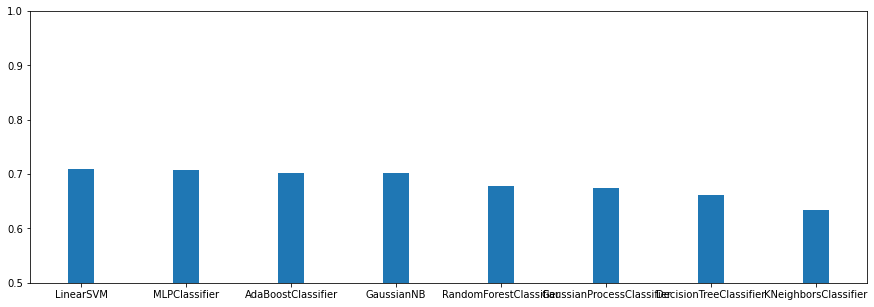

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.ylim([0.5, 1])
plt.bar(clf_scores.keys(), clf_scores.values(), width=0.25);